In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import arviz as az
import pymc as pm
import pytensor.tensor as pt
import scipy.stats as stats
from scipy.stats import skewnorm
import scipy as sp

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def dataimporter(filename,header=77,undregräns_b=2,övregränds_b=2.7):
    # Reading in the data file, removing header and converting it to a matrix
    data = pd.read_csv(filename, header=header)
    nummer = data.to_numpy()
    nummerdata = np.asarray(nummer[:-1,:], dtype="float")
    data = nummerdata
    
    #Fitting of the background and removal
    def bakgrund(x,c1,c2):
        return c1*x+c2
    bu = np.where(data[:,0]==find_nearest(data[:,0],undregräns_b))[0][0]
    bö = np.where(data[:,0]==find_nearest(data[:,0],övregränds_b))[0][0]
    xb = data[bu:bö,0]
    yb = data[bu:bö,1]
    poptb, popc = sp.optimize.curve_fit(bakgrund,xdata=xb,ydata=yb,p0=[0,0])
    data[:,1] = data[:,1]-bakgrund(data[:,0],*poptb)
    
    return nummerdata


def dataimporterclean(filename,header=70):
    # Reading in the data file, removing header and converting it to a matrix
    data = pd.read_csv(filename, header=header)
    nummer = data.to_numpy()
    nummerdata = np.asarray(nummer[:-1,:], dtype="float")
    return nummerdata

def bakgrund(x,c1,c2):
    return c1*x+c2

def plotter(ax,data,zo,colour,label,alpha = 1):
    # Function to plot spectrum
    ax.plot(data[:,0],data[:,1],zorder=zo, lw = 4, color = colour, label =label,alpha=alpha)
    ax.fill_between(data[:,0],data[:,1],zorder=zo, color = colour,alpha=alpha)
   
def find_nearest(array, value):
    # Function for finding closest value in array
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def data_integration(data,under=2,over=2.8,marginal=0.1):
    # Function to integrate the data between energies
    array = np.array([])
    for i in (data):
        intunder = np.where(i[:,0]==find_nearest(i[:,0],under))[0][0]
        intover = np.where(i[:,0]==find_nearest(i[:,0],over))[0][0]
        x=i[intunder:intover,0]
        y = i[intunder:intover,1]
        
        mitten = x[np.argmax(y)]

        u = np.where(x==find_nearest(x,mitten-marginal))[0][0]
        ö = np.where(x==find_nearest(x,mitten+marginal))[0][0]
        x=x[u:ö]
        y = y[u:ö]

        poptnorm,pcov = sp.optimize.curve_fit(norm,xdata=x,ydata=y,p0=[1,1,1])
        
        top1 =  np.sum(norm(x,*poptnorm))
        array = np.append(array,top1)
    return array


def data_integrationold(data,under=2.2,over=2.6,avgunder=2.65,avgover=2.8 ):
    # Function to integrate the data between energies
    array = np.array([])
    for i in (data):
        intunder = np.where(i[:,0]==find_nearest(i[:,0],under))
        intover = np.where(i[:,0]==find_nearest(i[:,0],over))
        placeunder = np.where(i[:,0]==find_nearest(i[:,0],avgunder))
        placeover = np.where(i[:,0]==find_nearest(i[:,0],avgover))
        
        intunder = np.reshape(intunder,-1)
        intover = np.reshape(intover,-1)
        placeunder = np.reshape(placeunder, -1)
        placeover = np.reshape(placeover, -1)

        # i[:,1] = i[:,1]-np.average(i[placeunder[0]:placeover[0],1])

        top1 = np.sum(i[intunder[0]:intover[0],1])
        array = np.append(array,top1)
    return array

def predict(signal,c):
    return c[0]*signal + c[1]

def readfile(arraynames):
    # Funstion to make it possible to import multiple files at the same time
    meaner = np.array([])
    for i in arraynames:
        temp = dataimporter(i)
        meaner = np.append(meaner,data_integration([temp]))
    return meaner

def skew_normal(x, a, loc, scale,amp):
    return amp*skewnorm.cdf(x, a, loc=loc, scale=scale)

def skew_normal_pdf(x, a, loc, scale,amp):
    return amp*skewnorm.pdf(x, a, loc=loc, scale=scale)
def norm(x,a,mean,sigma):
    return a*stats.norm.pdf(x,mean,sigma)

def invnorm(x,a,mean,sigma):
    return a*stats.invgauss.pdf(x,mean,sigma)

In [12]:

spectraldata10 = pd.DataFrame(columns=["tcps","thickness","thicknesserror","tcpserror"])


# A10_10k = readfile(["A10_10keV_250616_1.txt","A10_10keV_250616_2.txt","A10_10keV_250616_3.txt"])
# spectraldata10.loc["A10_10k"] = [np.mean(A10_10k),6.776032e-07,2.000000e-10,(np.max(A10_10k)-np.min(A10_10k))/2]


C7 = readfile(["20250425_10K_C7_1.txt","20250425_10K_C7_2.txt","20250425_10K_C7_3.txt"])
spectraldata10.loc["C7"] = [np.mean(C7),151.2e-9,0.3e-9,(np.max(C7)-np.min(C7))/2]

D2 = readfile(["20250425_10K_D2_1.txt","20250425_10K_D2_2.txt","20250425_10K_D2_3.txt"])
spectraldata10.loc["D2"] = [np.mean(D2),4.73e-9,0.46e-9,(np.max(D2)-np.min(D2))/2]

N10_A1 = readfile(["20250425_10K_N10_area1_1.txt","20250425_10K_N10_area1_2.txt","20250425_10K_N10_area1_3.txt"])
spectraldata10.loc["N10_A1"] = [np.mean(N10_A1),3.99e-9,0.38e-9,(np.max(N10_A1)-np.min(N10_A1))/2]

N10_A2 = readfile(["20250425_10K_N10_area2_1.txt","20250425_10K_N10_area2_2.txt","20250425_10K_N10_area2_3.txt"])
spectraldata10.loc["N10_A1"] = [np.mean(N10_A2),27.24e-9,0.4e-9,(np.max(N10_A2)-np.min(N10_A2))/2]

G10_A1 = readfile(["20250425_10K_G10_1.txt","20250425_10K_G10_2.txt","20250425_10K_G10_3.txt"])
spectraldata10.loc["G10_A1"] = [np.mean(G10_A1),9.39e-9,0.5137e-9,(np.max(G10_A1)-np.min(G10_A1))/2]

G10_A2 = readfile(["20250425_5K_G10_aera2.txt"])
spectraldata10.loc["G10_A1"] = [np.mean(G10_A2),6.65e-9,0.38e-9,(np.max(G10_A2)-np.min(G10_A2))/2]

zero = 0
spectraldata10.loc["zero"] = [np.mean(zero),0,0,(np.max(zero)-np.min(zero))/2]

spectraldata10.sort_values(by=['tcps'],inplace=True)


In [ ]:
spectraldata5 = pd.DataFrame(columns=["tcps","thickness","thicknesserror","tcpserror"])

C10_1_5k = readfile(["C10_1_5keV_250616_1.txt","C10_1_5keV_250616_2.txt","C10_1_5keV_250616_3.txt"])
spectraldata5.loc["C10_1_5k"] = [np.mean(C10_1_5k),5.472003e-08,2.679608e-10,(np.max(C10_1_5k)-np.min(C10_1_5k))/2]

spectraldata5.sort_values(by=['tcps'],inplace=True)

                   tcps     thickness  thicknesserror   tcpserror
C10_1_10k   5032.710670  5.472003e-08    2.679608e-10   76.959931
C10_2_10k   5927.545884  6.621984e-08    1.330124e-11   74.824181
H9_10keV   20947.623127  2.343753e-07    6.465787e-10   41.893249
A10_10k    29620.835289  6.776032e-07    2.000000e-10  115.006918


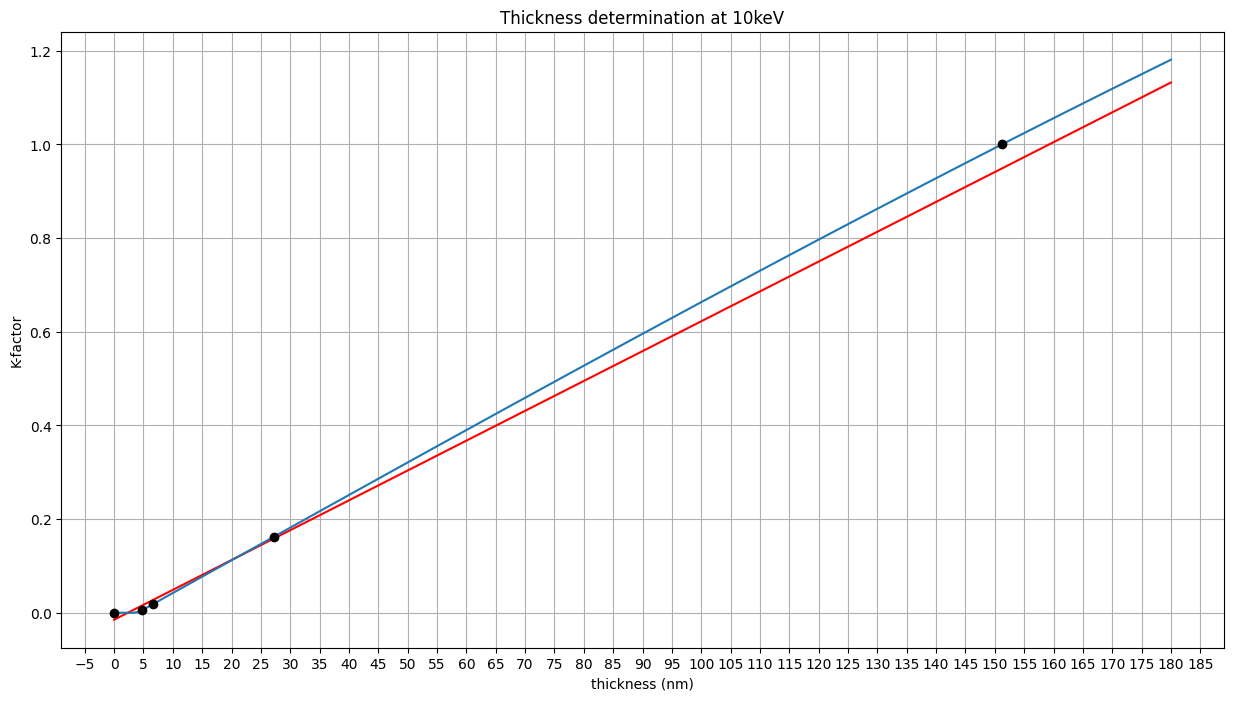

[ 0.00637227 -0.0147971 ]
[593.24136784   3.96907738 348.71874648   3.05693666]


In [13]:

x = spectraldata10["thickness"].to_numpy()*10**9
y = spectraldata10["tcps"].to_numpy()
y = y/y[-1]

thi = np.linspace(0,180,1000)

con10 = np.polyfit(x[:-1],y[:-1],1)

#Skew normal analasys
popt,pcov = sp.optimize.curve_fit(skew_normal,xdata=x,ydata=y,p0=[0.001,1,277.86757077762036,1])

fig, ax = plt.subplots(1)
fig.set_size_inches(15,8)
# Plotting for 10keV model
ax.errorbar(x,y,yerr = spectraldata10["tcpserror"].to_numpy()/(spectraldata10["tcps"].to_numpy()[-1]),xerr= spectraldata10["thicknesserror"].to_numpy()*10**9,color= "black",zorder = 4,fmt="o")
# ax.errorbar(spectraldata10points["thickness"].to_numpy()*10**9,spectraldata10points["tcps"].to_numpy(),yerr = spectraldata10points["tcpserror"].to_numpy(),xerr= spectraldata10points["thicknesserror"].to_numpy()*10**9,color= "black",zorder = 4,fmt="o")
ax.plot(thi,con10[0]*thi+con10[1],color = "red",zorder = 2)
ax.plot(thi,skew_normal(thi,*popt))
# ax.plot(thi,skew_normal(thi,*poptry))
# ax.scatter(x[8],y[8],zorder=20,color="yellow")

# ax.scatter(spectraldata5keVhelios["thickness"],spectraldata5keVhelios["tcps"],zorder=20)


ax.set_xlabel("thickness (nm)")
ax.set_ylabel("K-factor")
ax.xaxis.set_major_locator(ticker.MaxNLocator(40))
ax.grid(zorder=1)
# ax[i].legend()
# ax.set_ylim((-0.2,1.7))
# ax.set_xlim((-1,300))
ax.set_title("Thickness determination at 10keV")
# ax.set_xlim((0,10))
# ax.set_ylim((-0.05,0.2))
plt.show()
print(con10)
print(popt)

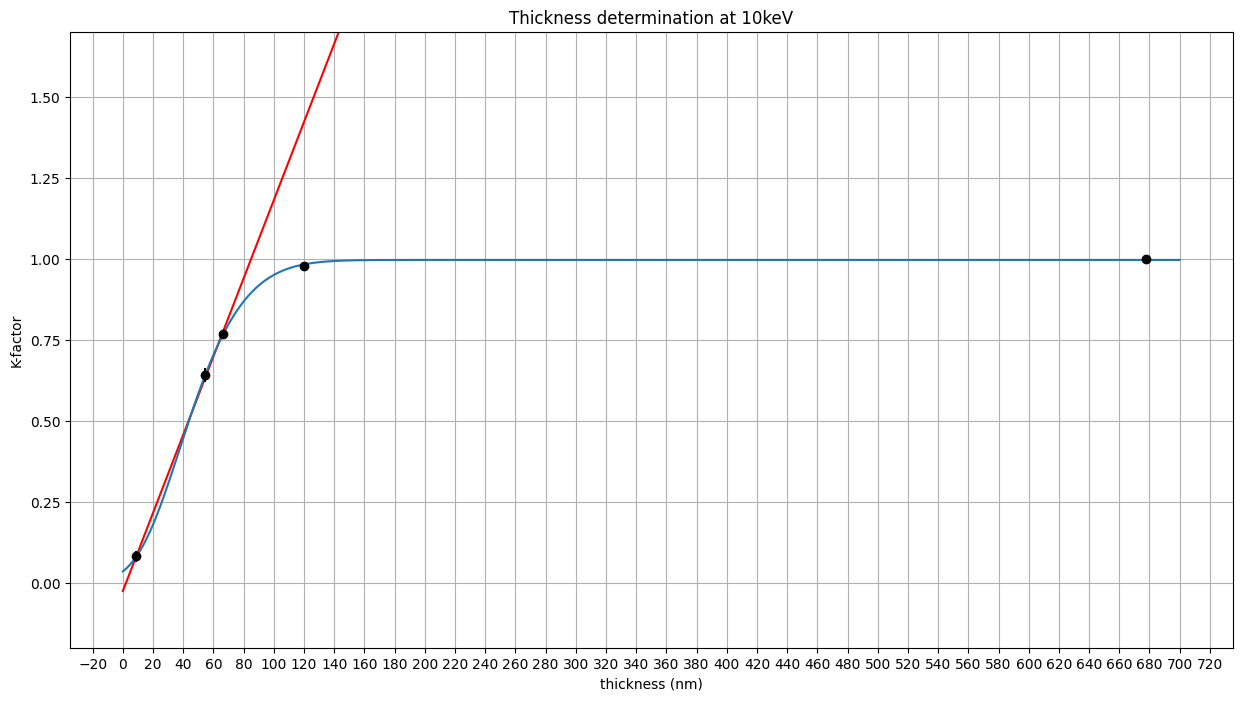

[ 0.01205674 -0.02500363]
[ 2.20849329 15.56964939 42.39170825  0.99609046]


In [22]:

x = spectraldata5["thickness"].to_numpy()*10**9
y = spectraldata5["tcps"].to_numpy()
y = y/y[-1]

thi = np.linspace(0,700,1000)

con10 = np.polyfit(x[:-2],y[:-2],1)

#Skew normal analasys
popt,pcov = sp.optimize.curve_fit(skew_normal,xdata=x,ydata=y,p0=[0.001,1,277.86757077762036,1])

fig, ax = plt.subplots(1)
fig.set_size_inches(15,8)
# Plotting for 10keV model
ax.errorbar(x,y,yerr = spectraldata5["tcpserror"].to_numpy()/(spectraldata5["tcps"].to_numpy()[-1]),xerr= spectraldata5["thicknesserror"].to_numpy()*10**9,color= "black",zorder = 4,fmt="o")
# ax.errorbar(spectraldata10points["thickness"].to_numpy()*10**9,spectraldata10points["tcps"].to_numpy(),yerr = spectraldata10points["tcpserror"].to_numpy(),xerr= spectraldata10points["thicknesserror"].to_numpy()*10**9,color= "black",zorder = 4,fmt="o")
ax.plot(thi,con10[0]*thi+con10[1],color = "red",zorder = 2)
ax.plot(thi,skew_normal(thi,*popt))
# ax.plot(thi,skew_normal(thi,*poptry))
# ax.scatter(x[8],y[8],zorder=20,color="yellow")

# ax.scatter(spectraldata5keVhelios["thickness"],spectraldata5keVhelios["tcps"],zorder=20)


ax.set_xlabel("thickness (nm)")
ax.set_ylabel("K-factor")
ax.xaxis.set_major_locator(ticker.MaxNLocator(40))
ax.grid(zorder=1)
# ax[i].legend()
ax.set_ylim((-0.2,1.7))
# ax.set_xlim((-1,300))
ax.set_title("Thickness determination at 10keV")
# ax.set_xlim((0,10))
# ax.set_ylim((-0.05,0.2))
plt.show()
print(con10)
print(popt)

In [186]:
def försök(filename,header=70,övregränds_b=5,undregräns_b=3,find_gauss_over=2,find_guass_under=2.7,marginal=0.1):
    #Import data
    data = pd.read_csv(filename, header=header)
    nummer = data.to_numpy()
    data = np.asarray(nummer[:-1,:], dtype="float")
    
    #Fitting of the background and removal
    def bakgrund(x,c1,c2):
        return c1*x+c2
    bu = np.where(data[:,0]==find_nearest(data[:,0],undregräns_b))[0][0]
    bö = np.where(data[:,0]==find_nearest(data[:,0],övregränds_b))[0][0]
    xb = data[bu:bö,0]
    yb = data[bu:bö,1]
    print(bu,bö)
    poptb, popc = sp.optimize.curve_fit(bakgrund,xdata=xb,ydata=yb,p0=[0,0])
    data[:,1] = data[:,1]-bakgrund(data[:,0],*poptb)
    
    
    #Fitting of gaussian on peak

    intunder = np.where(data[:,0]==find_nearest(data[:,0],find_gauss_over))[0][0]
    intover = np.where(data[:,0]==find_nearest(data[:,0],find_guass_under))[0][0]

    x=data[intunder:intover,0]
    y = data[intunder:intover,1]

    mitten = x[np.argmax(data[intunder:intover,1])]

    u = np.where(x==find_nearest(x,mitten-marginal))[0][0]
    ö = np.where(x==find_nearest(x,mitten+marginal))[0][0]
    x=x[u:ö]
    y = y[u:ö]

    poptnorm,pcov = sp.optimize.curve_fit(norm,xdata=x,ydata=y,p0=[1,1,1])
    
    return np.sum(norm(x,*poptnorm))
    

Here i will insvestigate the importing method and try to eliminate the background and get a good measurment

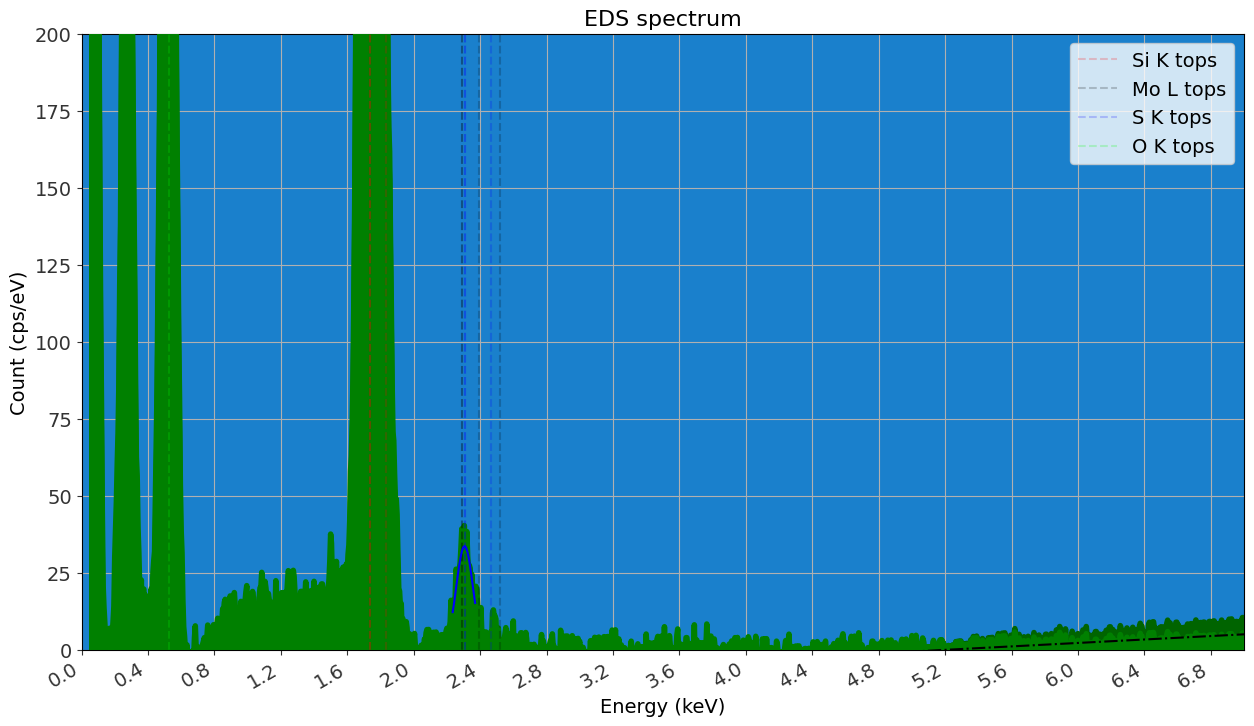

In [261]:
# Defining constants

Molines = [2.29316, 2.28985, 2.39481, 2.5183]
Silines = [1.73998,1.73938, 1.83594]
Slines = [2.30784,2.30664,2.46404]
Olines =[0.5249] 
Nticks = 20
xmax = 7
xmin = 0
ymax = 200
marginal = 0.07

# Creating plot figure and tick formating function
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
fmt = lambda x, pos: '{}'.format(x).rstrip('0')

data = dataimporter("Measurements 100724/D9_10k_100724_3.txt")

#Fitting of the background
def bakgrund(x,c1,c2):
    return c1*x+c2
bu = np.where(data[:,0]==find_nearest(data[:,0],3))[0][0]
bö = np.where(data[:,0]==find_nearest(data[:,0],5))[0][0]

xb = data[bu:bö,0]
yb = data[bu:bö,1]

poptb, popc = sp.optimize.curve_fit(bakgrund,xdata=xb,ydata=yb,p0=[0,0])

data[:,1] = data[:,1]-bakgrund(data[:,0],*poptb)

#Fitting of gaussian on peak

intunder = np.where(data[:,0]==find_nearest(data[:,0],2))[0][0]
intover = np.where(data[:,0]==find_nearest(data[:,0],2.7))[0][0]

x=data[intunder:intover,0]
y = data[intunder:intover,1]

mitten = x[np.argmax(data[intunder:intover,1])]

u = np.where(x==find_nearest(x,mitten-marginal))[0][0]
ö = np.where(x==find_nearest(x,mitten+marginal))[0][0]
x=x[u:ö]
y = y[u:ö]

poptnorm,pcov = sp.optimize.curve_fit(norm,xdata=x,ydata=y,p0=[1,1,1])

plotter(ax,dataimporter("Measurements 100724/D9_10k_100724_3.txt"),6,"darkgreen",None)
plotter(ax,data,6,"green",None)
# plotter(ax,dataimporter("Measurements 100724/D9_10k_100724_3.txt"),6,"green",None)
# plotter(ax,dataimporter("Spectras 300724/C15A1_10k_310724_1.txt"),7,"red",None)
# plotter(ax,dataimporter("Spectras 300724/C15A1_10k_310724_3.txt"),7,"blue",None)
# plotter(ax,dataimporter("Spectras 300724/B15_10k_310724_2.txt"),7,"red",None)
# plotter(ax,dataimporter("spectras 010824/Zero_3.txt"),8,"yellow",None)
# Setting parameters for plot
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right',fontsize=14)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.xaxis.set_major_locator(ticker.MaxNLocator(Nticks))
ax.grid(zorder = 1)
ax.set_xlim([xmin,xmax])
ax.set_ylim([0,ymax])
ax.set_facecolor((0.1, 0.5, 0.8))
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.xaxis.label.set_color('black')
ax.tick_params(colors=(0.2, 0.2, 0.2), which ='both')
ax.set_xlabel("Energy (keV)",fontsize=14)
ax.set_ylabel("Count (cps/eV)",fontsize=14)
ax.set_title("EDS spectrum",fontsize=16)

ax.vlines(Silines,-1000,ymax, colors="red",linestyles="dashed", alpha = 0.2, label="Si K tops",zorder = 10)#Silicon K tops
ax.vlines(Molines,-1000,ymax, colors="black",linestyles="dashed",alpha = 0.2,label= "Mo L tops",zorder = 10)#Mo L tops
ax.vlines(Slines,-1000,ymax, colors=(0,0,1),linestyles="dashed",alpha = 0.2,label= "S K tops",zorder = 10)#S K tops
ax.vlines(Olines,-1000,ymax, colors=(0,1,0),linestyles="dashed",alpha = 0.2,label= "O K tops",zorder = 10)#S K tops
ax.legend(fontsize=14)

# ax.hlines([12.5,16.5],-1000,ymax, colors="black",linestyles="dashed",alpha = 0.7,label= "Mo L tops",zorder = 10)
# ax.plot(data[intunder:intover,0],skew_normal_pdf(data[intunder:intover,0],*popt),zorder=10,color="w")
ax.plot(x,norm(x,*poptnorm),zorder=10,color="b")
ax.plot(data[:,0],bakgrund(data[:,0],*poptb),zorder=10,color="black",linestyle="-.")
plt.show()